In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import accuracy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc


Bài toán ban đầu chỉ gợi ý những phim mà nhóm chưa xem, mở rộng bài toán bằng cách tính độ tương đồng giữa title phim và thể loại phim để đề xuất những phim mà nhóm người dùng chưa xem sao cho có độ tương đồng với những phim mà nhóm đã có ít nhất 1 người xem


In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=column_names)

movie_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
                 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|', encoding='latin-1', header=None, names=movie_columns)
movies

,item_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Tạo ma trận người dùng - phim
user_movie_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
user_movie_matrix

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Tạo ma trận phim - thể loại từ u.item
movie_genres = movies.set_index('item_id')[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                            'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                                            'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
movie_genres

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1679,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1680,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [5]:
# Tính ma trận độ tương đồng giữa các phim dựa trên thể loại
movie_similarity = cosine_similarity(movie_genres)

# Tạo DataFrame từ ma trận độ tương đồng
movie_similarity_df = pd.DataFrame(movie_similarity, index=movie_genres.index, columns=movie_genres.index)
movie_similarity_df

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
2,0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
3,0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
4,0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
5,0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
1679,0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
1680,0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107


Giả sử nhóm đã xem phim A và B, và ta đang tính điểm gợi ý cho phim X.
<br>Độ tương đồng giữa X và A là 0.9.
<br>Độ tương đồng giữa X và B là 0.8.
<br>Điểm gợi ý cho phim X = (0.9 + 0.8)/2 = 0.85.
<br>Để đảm bảo điểm số được tính dựa trên trung bình của các điểm tương đồng, ta chia tổng điểm cho số lượng phim đã xem.

# Average Strategy

In [6]:
def recommend_movies_for_group(group_user_ids, user_movie_matrix, movie_similarity_df, top_n=10):
    # Tìm các phim mà ít nhất một thành viên trong nhóm đã xem
    group_seen_movies = (user_movie_matrix.loc[group_user_ids] > 0).any(axis=0)

    # Tìm các phim mà chưa có thành viên nào trong nhóm đã xem
    group_unseen_movies = (user_movie_matrix.loc[group_user_ids] == 0).all(axis=0)

    # Tạo một Series để lưu điểm số cho các phim chưa xem
    recommendation_scores = pd.Series(0, index=movie_similarity_df.columns)

    # Cộng dồn điểm số dựa trên độ tương đồng và trọng số của người dùng
    for movie in group_unseen_movies[group_unseen_movies].index:
            if movie in movie_similarity_df.index:
                # Cộng dồn điểm số cho phim chưa xem dựa trên độ tương đồng và trọng số
                recommendation_scores += movie_similarity_df[movie] 

    # Đồng bộ hóa chỉ số giữa recommendation_scores và group_unseen_movies
    recommendation_scores_aligned = recommendation_scores.reindex(index=group_unseen_movies.index, fill_value=0)

    # Chỉ giữ lại các phim chưa xem
    recommendation_scores = recommendation_scores_aligned[group_unseen_movies]

    # Sắp xếp và lấy top N phim
    top_recommendations = recommendation_scores.sort_values(ascending=False).head(top_n)

    return top_recommendations


group_user_ids = [1, 2, 3]
group_recommendations = recommend_movies_for_group(group_user_ids, user_movie_matrix, movie_similarity_df)

recommended_movies = movies[movies['item_id'].isin(group_recommendations.index)][['title']]
print(recommended_movies)

                           title
480        Apartment, The (1960)
711               Tin Men (1987)
714            To Die For (1995)
722      Boys on the Side (1995)
736                Sirens (1994)
786             Roommates (1995)
1102                Trust (1990)
1164            Big Bully (1996)
1169  Spanking the Monkey (1994)
1185         Inkwell, The (1994)


## Train, Test split

In [7]:
def train_test_split(df, test_size=0.2):
    test = df.sample(frac=test_size, random_state=42)
    train = df.drop(test.index)
    return train, test

train_ratings, test_ratings = train_test_split(ratings)

# Tạo ma trận người dùng - phim từ tập huấn luyện
user_movie_matrix_train = train_ratings.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Tạo ma trận người dùng - phim từ tập kiểm tra để so sánh
user_movie_matrix_test = test_ratings.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)


## Evaluate Average Strategy

In [8]:
# Bước 1: Tải dữ liệu và chia thành tập huấn luyện và kiểm tra
ratings_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                           names=['user_id', 'item_id', 'rating', 'timestamp'])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
def train_test_split(df, test_size=0.2):
    test = df.sample(frac=test_size, random_state=42)
    train = df.drop(test.index)
    return train, test

train_ratings, test_ratings = train_test_split(ratings)

# Tạo ma trận người dùng - phim từ tập huấn luyện
user_movie_matrix_train = train_ratings.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Tạo ma trận người dùng - phim từ tập kiểm tra để so sánh
user_movie_matrix_test = test_ratings.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)


# Bước 2: Tải thông tin phim
movie_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
                 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                          encoding='latin-1', header=None, names=movie_columns)

# Tính toán ma trận độ tương đồng giữa các phim dựa trên thể loại
movie_genres = movies_data.set_index('item_id')[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                                                'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

# Tính ma trận độ tương đồng giữa các phim
movie_similarity = cosine_similarity(movie_genres)
movie_similarity_df = pd.DataFrame(movie_similarity, index=movie_genres.index, columns=movie_genres.index)

# Đảm bảo các phim trong cả ma trận khuyến nghị và tập kiểm tra là chung
common_movie_ids = user_movie_matrix_train.columns.intersection(movie_similarity_df.index)

# Bước 3: Hàm đề xuất phim theo phương pháp average strategy
def recommend_movies_for_group(group_user_ids, user_movie_matrix, movie_similarity_df, top_n=10):
    # Chỉ xét các phim có chung trong cả hai tập
    user_movie_matrix = user_movie_matrix[common_movie_ids]
    movie_similarity_df = movie_similarity_df.loc[common_movie_ids, common_movie_ids]

    # Tìm các phim mà ít nhất một thành viên trong nhóm đã xem
    group_seen_movies = (user_movie_matrix.loc[group_user_ids] > 0).any(axis=0)

    # Tìm các phim mà chưa có thành viên nào trong nhóm đã xem
    group_unseen_movies = (user_movie_matrix.loc[group_user_ids] == 0).all(axis=0)

    # Tạo một Series để lưu điểm số cho các phim chưa xem
    recommendation_scores = pd.Series(0, index=movie_similarity_df.columns)

    # Cộng dồn điểm số dựa trên độ tương đồng của các phim đã xem
    for movie in group_seen_movies[group_seen_movies].index:
        recommendation_scores += movie_similarity_df[movie]

    # Chỉ giữ lại các phim chưa xem
    recommendation_scores = recommendation_scores[group_unseen_movies]

    # Lấy top N phim
    top_recommendations = recommendation_scores.sort_values(ascending=False).head(top_n)
    return top_recommendations

Confusion Matrix:
 [[0 9]
 [0 1]]
Precision: 0.1
Recall: 1.0
F1-Score: 0.18181818181818182


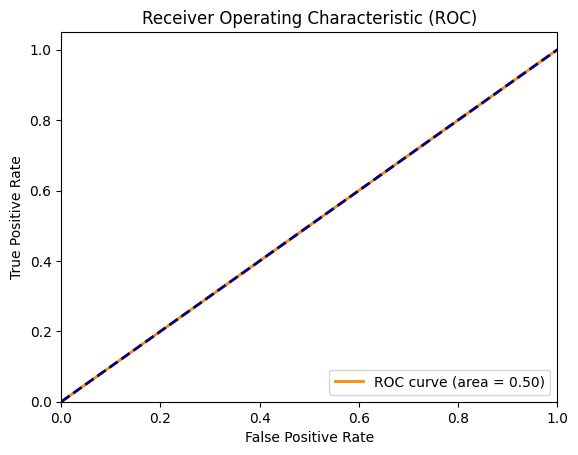

In [9]:
def evaluate_recommendation(group_user_ids, user_movie_matrix_train, user_movie_matrix_test, movie_similarity_df, top_n=10):
    # Gợi ý phim dựa trên tập huấn luyện
    recommended_movies = recommend_movies_for_group(group_user_ids, user_movie_matrix_train, movie_similarity_df, top_n=top_n)

    # Lấy các phim mà nhóm đã thực sự xem trong tập kiểm tra (rating > 0)
    group_actual_movies = (user_movie_matrix_test.loc[group_user_ids] > 0).any(axis=0)
    actual_movies = group_actual_movies[group_actual_movies].index

    # Đánh giá: Dự đoán xem phim được gợi ý có thuộc tập thực tế không (1 nếu có, 0 nếu không)
    y_true = [1 if movie in actual_movies else 0 for movie in recommended_movies.index]
    y_pred = [1] * len(recommended_movies)  # Các phim được gợi ý đều là dự đoán dương tính (positive)

    # Tính toán các chỉ số đánh giá khác
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # In các chỉ số
    print("Confusion Matrix:\n", conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    # Bước 4: Tính toán và vẽ ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return precision, recall, f1, roc_auc


# Ví dụ: Đánh giá hệ thống gợi ý cho nhóm người dùng [1, 2, 3]
group_user_ids = [1, 2, 3]
precision, recall, f1, roc_auc = evaluate_recommendation(group_user_ids, user_movie_matrix_train, user_movie_matrix_test, movie_similarity_df, top_n=10)


evaluate_recommendation_roc()
- Ưu điểm:

Hàm này tập trung chính xác vào việc tính toán ROC Curve và ROC-AUC bằng cách sử dụng điểm số liên tục từ hệ thống khuyến nghị. Đây là cách xử lý đúng cho bài toán ROC, vì ROC Curve cần các giá trị liên tục hoặc xác suất thay vì nhị phân.
Đồng bộ hóa chỉ số: Hàm này đồng bộ hóa chỉ số giữa các phim được gợi ý và các phim thực tế mà nhóm đã xem. Điều này giúp tránh lỗi khi các chỉ số không khớp nhau, điều có thể xảy ra khi xử lý dữ liệu phim mà nhóm đã xem và các phim được gợi ý.

- Nhược điểm:
Hàm này không tính Precision, Recall, F1-Score. Nếu bạn cần các chỉ số phân loại cùng với ROC-AUC, hàm này không cung cấp đầy đủ thông tin.
Điểm quan trọng:

Hàm này xử lý chính xác việc tính toán ROC Curve và ROC-AUC bằng cách sử dụng điểm số liên tục từ hệ thống khuyến nghị mà không chuyển đổi thành nhị phân. Đây là cách tiếp cận tốt hơn nếu mục tiêu chính của bạn là đánh giá khả năng phân biệt của hệ thống qua ROC-AUC

# Tính trọng số của trung bình rating

bây giờ chúng ta không làm theo cách average strategy nữa, bây giờ chúng ta sẽ làm theo cách mới hơn mà cách đó sẽ làm hài lòng mọi người hơn bằng cách: tính toán trọng số cho group_users_id nếu người nào rating các bộ phim càng thấp thì trọng số của họ càng cao nghĩa là độ "khó tính" của họ càng cao thế nên bây giờ hãy đề xuất những phim mà nhóm người đó chưa xem sao cho những phim chưa xem có độ tương đồng với những phim mà ít nhất một người trong nhóm đã rating mà điều kiện ở đây là những phim có độ tương đồng với phim người "khó tính" rating sẽ có độ tương đồng cao hơn nghĩa là dễ được đề xuất hơn

### Ý tưởng:
Trọng số của người dùng: Người dùng có xu hướng đánh giá phim thấp hơn sẽ được coi là "khó tính", và họ sẽ có trọng số cao hơn trong quá trình gợi ý phim. Điều này có nghĩa là khi tính điểm gợi ý cho một phim, phim càng giống với các phim mà người "khó tính" đã đánh giá, điểm gợi ý của phim đó sẽ càng cao.
Đề xuất phim: Chúng ta sẽ tìm các phim chưa xem của nhóm và đề xuất những phim có độ tương đồng cao với những phim đã được người "khó tính" đánh giá.

### Các bước thực hiện:
1. Tính trọng số cho mỗi người dùng trong nhóm: Người dùng có xu hướng đánh giá thấp hơn sẽ được coi là "khó tính" và sẽ có trọng số cao hơn.
2. Tính điểm gợi ý cho các phim chưa xem: Điểm gợi ý sẽ được tính dựa trên trọng số của người dùng và độ tương đồng giữa phim chưa xem và phim đã xem.
3. Đề xuất phim: Chọn ra các phim có điểm số cao nhất để gợi ý cho nhóm.<br>
- giải thích cách tính trọng số:
Trọng số người dùng = `1 / (mean rating của người dùng)`. Người dùng có rating trung bình thấp hơn sẽ có trọng số cao hơn vì mẫu càng lớn thì trọng số càng nhỏ và độ "khó tính" sẽ càng cao

Giả sử nhóm có 3 người:

- Người A có rating trung bình là 2.0 (rất thấp), nên trọng số của họ sẽ là 1 / 2.0 = 0.5.
- Người B có rating trung bình là 4.0, trọng số của họ sẽ là 1 / 4.0 = 0.25.
- Người C có rating trung bình là 3.0, trọng số là 1 / 3.0 = 0.33.</br>
Khi tính điểm gợi ý cho các phim chưa xem, hệ thống sẽ ưu tiên những phim có độ tương đồng cao với các phim mà người A (khó tính nhất) đã đánh giá, vì trọng số của người A cao hơn.

In [10]:
def recommend_movies_for_group_weighted(group_user_ids, user_movie_matrix, movie_similarity_df, top_n=10):
    # Tính trọng số cho mỗi người dùng dựa trên mean rating (người "khó tính" có trọng số cao hơn)
    user_weights = {}
    for user_id in group_user_ids:
        user_ratings = user_movie_matrix.loc[user_id]
        mean_rating = user_ratings[user_ratings > 0].mean()  # Tính rating trung bình của người dùng
        if pd.notna(mean_rating) and mean_rating > 0:
            user_weights[user_id] = 1 / mean_rating  # Trọng số càng cao nếu rating trung bình càng thấp
        else:
            user_weights[user_id] = 0  # Nếu người dùng chưa rating phim nào, trọng số bằng 0

    # Tìm các phim mà ít nhất một thành viên trong nhóm đã xem
    group_seen_movies = (user_movie_matrix.loc[group_user_ids] > 0).any(axis=0)

    # Tìm các phim mà chưa có thành viên nào trong nhóm đã xem
    group_unseen_movies = (user_movie_matrix.loc[group_user_ids] == 0).all(axis=0)

    # Tạo một Series để lưu điểm số cho các phim chưa xem
    recommendation_scores = pd.Series(0, index=movie_similarity_df.columns)

    # Cộng dồn điểm số dựa trên độ tương đồng và trọng số của người dùng
    for user_id in group_user_ids:
        user_weight = user_weights[user_id]  # Lấy trọng số của người dùng
        user_seen_movies = user_movie_matrix.loc[user_id] > 0  # Các phim mà người dùng đã xem

        for movie in user_seen_movies[user_seen_movies].index:
            if movie in movie_similarity_df.index:
                # Cộng dồn điểm số cho phim chưa xem dựa trên độ tương đồng và trọng số
                recommendation_scores += movie_similarity_df[movie] * user_weight

    # Đồng bộ hóa chỉ số giữa recommendation_scores và group_unseen_movies
    recommendation_scores_aligned = recommendation_scores.reindex(index=group_unseen_movies.index, fill_value=0)

    # Chỉ giữ lại các phim chưa xem
    recommendation_scores = recommendation_scores_aligned[group_unseen_movies]

    # Sắp xếp và lấy top N phim
    top_recommendations = recommendation_scores.sort_values(ascending=False).head(top_n)

    return top_recommendations


group_user_ids = [1, 2, 3]
group_recommendations = recommend_movies_for_group_weighted(group_user_ids, user_movie_matrix, movie_similarity_df)

recommended_movies = movies[movies['item_id'].isin(group_recommendations.index)][['title']]
print(recommended_movies)

                                title
597           Big Squeeze, The (1996)
1240                  Van, The (1996)
1294        Kicked in the Head (1997)
1295             Indian Summer (1996)
1307                 Babyfever (1994)
1310         Waiting to Exhale (1995)
1311     Pompatus of Love, The (1996)
1332  Midnight Dancers (Sibak) (1994)
1338      Stefano Quantestorie (1993)
1402  Caro Diario (Dear Diary) (1994)


Confusion Matrix:
 [[0 9]
 [0 1]]
Precision: 0.1
Recall: 1.0
F1-Score: 0.18181818181818182


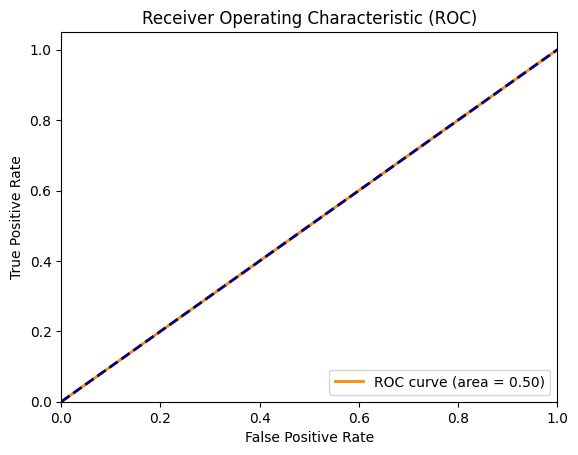

In [11]:
def evaluate_recommendation(group_user_ids, user_movie_matrix_train, user_movie_matrix_test, movie_similarity_df, top_n=10):
    # Gợi ý phim dựa trên tập huấn luyện
    recommended_movies = recommend_movies_for_group_weighted(group_user_ids, user_movie_matrix_train, movie_similarity_df, top_n=top_n)

    # Lấy các phim mà nhóm đã thực sự xem trong tập kiểm tra (rating > 0)
    group_actual_movies = (user_movie_matrix_test.loc[group_user_ids] > 0).any(axis=0)
    actual_movies = group_actual_movies[group_actual_movies].index

    # Đánh giá: Dự đoán xem phim được gợi ý có thuộc tập thực tế không (1 nếu có, 0 nếu không)
    y_true = [1 if movie in actual_movies else 0 for movie in recommended_movies.index]
    y_pred = [1] * len(recommended_movies)  # Các phim được gợi ý đều là dự đoán dương tính (positive)

    # Tính toán các chỉ số đánh giá khác
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # In các chỉ số
    print("Confusion Matrix:\n", conf_matrix)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    # Bước 4: Tính toán và vẽ ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return precision, recall, f1, roc_auc


# Ví dụ: Đánh giá hệ thống gợi ý cho nhóm người dùng [1, 2, 3]
group_user_ids = [1, 2, 3]
precision, recall, f1, roc_auc = evaluate_recommendation(group_user_ids, user_movie_matrix_train, user_movie_matrix_test, movie_similarity_df, top_n=10)


# Ranking Vector

In [12]:
import pandas as pd
import numpy as np

In [13]:


# Tải dữ liệu MovieLens 100k
ratings_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Chọn một nhóm người dùng (ví dụ: nhóm [1, 2, 3, 4, 5])
group_user_ids = [1, 2, 3, 4, 5]

# Lấy thông tin phim
movie_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
                 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|', encoding='latin-1', header=None, names=movie_columns)

# Tạo ma trận người dùng - phim
user_movie_matrix = ratings_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Lấy ma trận ratings của nhóm người dùng
group_ratings = user_movie_matrix.loc[group_user_ids]

# Hàm ReLU
def ReLU(k):
    return max(0, k)

# Bước 1: Tính các giá trị c cho từng người dùng dựa trên những người khác trong nhóm
def calculate_c_values(group_ratings):
    c_values = []
    
    for i in range(group_ratings.shape[0]):
        v1 = group_ratings.iloc[i].values
        c_total = 0

        # Tính c cho tất cả những người còn lại
        for j in range(group_ratings.shape[0]):
            if i != j:
                v_other = group_ratings.iloc[j].values
                c_total += sum(ReLU(v_other[k] - v1[k]) for k in range(len(v1)))

        # Lưu tổng giá trị c cho người dùng i
        c_values.append(c_total)
    
    return c_values

# Tính trọng số của nhóm người dùng
def calculate_weights(group_ratings):
    # Tính tổng giá trị c cho mỗi người
    c_values = calculate_c_values(group_ratings)
    
    # Tính tổng tất cả các giá trị c
    sum_c = sum(c_values)

    # Tính trọng số dựa trên giá trị c của mỗi người dùng
    weights = [c_val / sum_c for c_val in c_values]
    return weights

# Tính trọng số của nhóm người dùng
weights = calculate_weights(group_ratings)

# In ra các trọng số của từng người
print("\nTrọng số của từng người dùng:")
for user_id, weight in zip(group_user_ids, weights):
    print(f"Người dùng {user_id}: {weight:.4f}")

# Bước 2: Tính điểm trung bình có trọng số cho mỗi bộ phim
def calculate_weighted_ratings(group_ratings, weights):
    weighted_ratings = np.zeros(group_ratings.shape[1])  # Số phim
    for j in range(group_ratings.shape[1]):
        weighted_sum = 0
        for i in range(group_ratings.shape[0]):
            weighted_sum += group_ratings.iloc[i, j] * weights[i]
        weighted_ratings[j] = weighted_sum
    return weighted_ratings

# Tính điểm trung bình có trọng số
weighted_ratings = calculate_weighted_ratings(group_ratings, weights)

# Lấy thông tin phim từ item_id trong movies_data
movie_ids = group_ratings.columns
movies = movies_data.set_index('item_id').loc[movie_ids]['title'].values


# Bước 3: Đề xuất top 10 bộ phim có điểm trung bình có trọng số cao nhất
sorted_movie_indices = np.argsort(weighted_ratings)[::-1]
sorted_movies = [movies[i] for i in sorted_movie_indices]
sorted_scores = [weighted_ratings[i] for i in sorted_movie_indices]

# Lấy ra top 10 phim
top_10_movies = sorted_movies[:10]
top_10_scores = sorted_scores[:10]

print("\nTop 10 bộ phim có điểm trung bình có trọng số cao nhất:")
for movie, score in zip(top_10_movies, top_10_scores):
    print(f"{movie}: {score:.4f}")



Trọng số của từng người dùng:
Người dùng 1: 0.0929
Người dùng 2: 0.2306
Người dùng 3: 0.2496
Người dùng 4: 0.2549
Người dùng 5: 0.1720

Top 10 bộ phim có điểm trung bình có trọng số cao nhất:
Star Wars (1977): 3.5798
Ulee's Gold (1997): 2.9460
Contact (1997): 2.9301
Air Force One (1997): 2.6963
Fargo (1996): 2.4771
Return of the Jedi (1983): 2.3227
Desperate Measures (1998): 2.2733
Cop Land (1997): 2.2733
Scream (1996): 2.2108
In & Out (1997): 2.1970


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [15]:
ratings_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                           names=['user_id', 'item_id', 'rating', 'timestamp'])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Tạo ma trận người dùng - phim cho tập huấn luyện
user_movie_matrix_train = train_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Tạo ma trận người dùng - phim cho tập kiểm tra
user_movie_matrix_test = test_data.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

# Chọn một nhóm người dùng (ví dụ: nhóm [1, 2, 3, 4, 5])
group_user_ids = [1, 2, 3, 4, 5]

# Kiểm tra xem các người dùng có trong tập huấn luyện và tập kiểm tra không
group_user_ids_train = [uid for uid in group_user_ids if uid in user_movie_matrix_train.index]
group_user_ids_test = [uid for uid in group_user_ids if uid in user_movie_matrix_test.index]

# Lấy thông tin phim
movie_columns = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
                 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_data = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                          encoding='latin-1', header=None, names=movie_columns)

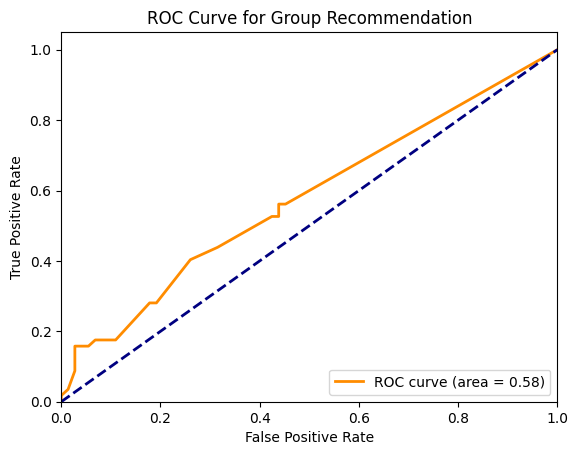

ROC AUC: 0.5765


In [16]:
def ReLU(k):
    return max(0, k)

# Tính trọng số của nhóm người dùng
def calculate_c_values(group_ratings):
    c_values = []
    
    for i in range(group_ratings.shape[0]):
        v1 = group_ratings.iloc[i].values
        c_total = 0

        # Tính c cho tất cả những người còn lại
        for j in range(group_ratings.shape[0]):
            if i != j:
                v_other = group_ratings.iloc[j].values
                c_total += sum(ReLU(v_other[k] - v1[k]) for k in range(len(v1)))

        # Lưu tổng giá trị c cho người dùng i
        c_values.append(c_total)
    
    return c_values

def calculate_weights(group_ratings):
    c_values = calculate_c_values(group_ratings)
    sum_c = sum(c_values)
    weights = [c_val / sum_c if sum_c != 0 else 1/len(c_values) for c_val in c_values]
    return weights

# Lấy ma trận ratings của nhóm người dùng trong tập huấn luyện
group_ratings_train = user_movie_matrix_train.loc[group_user_ids_train]

# Nếu nhóm không đủ người dùng trong tập huấn luyện, dừng lại
if group_ratings_train.empty:
    print("Không có đủ người dùng trong tập huấn luyện.")
else:
    # Tính trọng số
    weights = calculate_weights(group_ratings_train)

    # Tính điểm trung bình có trọng số cho mỗi bộ phim
    def calculate_weighted_ratings(group_ratings, weights):
        weighted_ratings = np.zeros(group_ratings.shape[1])  # Số phim
        for j in range(group_ratings.shape[1]):
            weighted_sum = 0
            for i in range(group_ratings.shape[0]):
                weighted_sum += group_ratings.iloc[i, j] * weights[i]
            weighted_ratings[j] = weighted_sum
        return weighted_ratings

    weighted_ratings = calculate_weighted_ratings(group_ratings_train, weights)

    # Lấy thông tin phim từ item_id trong movies_data
    movie_ids = group_ratings_train.columns
    movies = movies_data.set_index('item_id').loc[movie_ids]['title'].values

    # Tạo danh sách các dự đoán và nhãn thực tế

    # Dự đoán: Các phim được gợi ý với điểm số dự đoán
    predictions = pd.DataFrame({
        'item_id': movie_ids,
        'weighted_rating': weighted_ratings
    })

    # Nhãn thực tế: Các phim mà nhóm đã thực sự đánh giá cao trong tập kiểm tra
    group_ratings_test = user_movie_matrix_test.loc[group_user_ids_test]
    group_ratings_test = group_ratings_test.reindex(columns=movie_ids, fill_value=0)

    # Tạo nhãn thực tế (y_true)
    y_true = (group_ratings_test.values.flatten() >= 4).astype(int)

    # Điểm dự đoán (y_scores)
    y_scores = np.repeat(weighted_ratings, len(group_user_ids_test))

    # Lọc những giá trị đã đánh giá trong tập kiểm tra
    mask = group_ratings_test.values.flatten() != 0
    y_true = y_true[mask]
    y_scores = y_scores[mask]

    # Tính toán ROC Curve và ROC AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Vẽ ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Group Recommendation')
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC AUC: {roc_auc:.4f}")
